# Mod 5 Project : Flight delays at Newark Airport
### Khairul Omar & Ly Nguyenova

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import progressbar
import warnings
import time
from datetime import datetime
from library import *
warnings.simplefilter("ignore")

# 1. Executive Summary

Text here

# 2. Data Import

In [2]:
df = pd.read_csv('newark_flights.csv')
df.columns

Index(['Unnamed: 0', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE',
       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

# 3. Data Cleansing

### 3.1 First round of cleansing

In [3]:
# Clean up null

df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop(df[(df['ORIGIN_AIRPORT']=='EWR') & (df['DEPARTURE_TIME'].isna())].index, inplace=True)
df.drop(df[(df['DESTINATION_AIRPORT']=='EWR') & (df['ARRIVAL_TIME'].isna())].index, inplace=True)
df.drop(df[(df['ARRIVAL_DELAY'].isna())].index, inplace=True)
delay = list(df[df.columns[-6:]].columns)
for cols in delay:
    if df[cols].isna().any():
        df[cols].fillna(value=0, inplace=True)

In [4]:
# df.isna().sum()

In [5]:
# Clean up date format
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

# Clean up Arrival time format
df["HOUR"] = df["SCHEDULED_ARRIVAL"].apply(lambda x: int(str(int(x))[0:2]) if len(str(int(x)))==4 else int(str(int(x))[0:1]))
df["MINUTE"]  = df["SCHEDULED_ARRIVAL"].apply(lambda x: int(str(int(x))[-2:]))
df["SCHEDULED_ARRIVAL"] = pd.to_datetime(df[['YEAR','MONTH', 'DAY', 'HOUR', 'MINUTE']])
df["SCH_ARR_TEMP"] = pd.to_datetime(df[['YEAR','MONTH', 'DAY', 'HOUR']])

# Clean up Departure time format
df["HOUR"] = df["SCHEDULED_DEPARTURE"].apply(lambda x: int(str(int(x))[0:2]) if len(str(int(x)))==4 else int(str(int(x))[0:1]))
df["MINUTE"]  = df["SCHEDULED_DEPARTURE"].apply(lambda x: int(str(int(x))[-2:]))
df["SCHEDULED_DEPARTURE"] = pd.to_datetime(df[['YEAR','MONTH', 'DAY', 'HOUR', 'MINUTE']])
df["SCH_DEP_TEMP"] = pd.to_datetime(df[['YEAR','MONTH', 'DAY', 'HOUR']])

# Temporary column for Darksky data mapping
df["NYC_TIME_TEMP"] = df.apply(lambda row: row['SCH_ARR_TEMP'] if row['DESTINATION_AIRPORT'] == 'EWR' else row['SCH_DEP_TEMP'], axis=1)

# Combine United Express (EV) as mainline United (UA)
df['AIRLINE'] = df.apply(lambda row: 'UA' if row['AIRLINE'] == 'EV' else row['AIRLINE'], axis=1)

# Simplify delay reason columns - for EDA only, not as predictors
df['DELAY_REASON'] = df.apply(lambda row: 'Air system' if row['AIR_SYSTEM_DELAY'] == 1 else 
                              ('Security' if row['SECURITY_DELAY'] == 1 else 
                               ('Airline' if row['AIRLINE_DELAY'] == 1 else 
                                ('Late aircraft' if row['LATE_AIRCRAFT_DELAY'] == 1 else 
                                 ('Weather' if row['WEATHER_DELAY'] == 1 else 0)))), axis=1)
    
# Dummy variables for Arrival or Departure
df['DEPARTURE'] = df.apply(lambda row: 0 if row['DESTINATION_AIRPORT'] == 'EWR' else 1, axis=1)

# Time in reference to Newark only
df['SCHEDULED_TIME'] = df.apply(lambda row: row['SCHEDULED_DEPARTURE'] if row['DEPARTURE'] == 1 else row['SCHEDULED_ARRIVAL'], axis=1)

# Time in reference to Newark only - Hour
df['SCHEDULED_HOUR'] = df['SCHEDULED_TIME'].apply(lambda row: row.hour)

# Dummy variables for target (Delay)
df['DELAY'] = df.apply(lambda row: 1 if (row['DEPARTURE']==1)&(row['DEPARTURE_DELAY']>15) else (1 if (row['DEPARTURE']==0)&(row['ARRIVAL_DELAY']>15) else 0), axis=1)

In [6]:
# Retain only relevant columns

keep_columns = ['DATE', 'DAY_OF_WEEK', 'SCHEDULED_HOUR', 'DEPARTURE', 'AIRLINE',
                'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DISTANCE', 'DELAY', 'DELAY_REASON']
temp_columns = ['NYC_TIME_TEMP', 'TAIL_NUMBER'] # temporary for mapping only
df = df[keep_columns + temp_columns]

### 3.2 Join external data on Weather and Aircraft Age

In [7]:
# Import and clean DarkSky weather database
# See separate notbook: dark_sky.ipynb for details on data extraction

weather = pd.DataFrame(pd.read_csv('newark_weather.csv')) # saved output from DarkSky
weather.drop('Unnamed: 0', axis=1, inplace=True)
weather['temperature'] = weather['temperature'].apply(lambda row: round(row,1))
weather['nyc_time'] = pd.to_datetime(weather['nyc_time'])
weather = weather.rename(columns={'icon':'weather'})
weather = weather.set_index('nyc_time')
weather = weather[weather.columns[:-4]]
weather.head()

,weather,precipIntensity,temperature,windSpeed,visibility
nyc_time,,,,,
2015-01-01 00:00:00,clear,0.0,-4.4,1.66,9.997
2015-01-01 01:00:00,clear,0.0,-4.4,1.91,9.997
2015-01-01 02:00:00,clear,0.0,-4.4,2.38,9.997
2015-01-01 03:00:00,clear,0.0,-5.0,1.85,9.997
2015-01-01 04:00:00,clear,0.0,-4.4,2.77,9.997


In [8]:
# Join main data with DarkSky weather database

df = df.join(weather, on='NYC_TIME_TEMP')
df.drop('NYC_TIME_TEMP', axis=1, inplace=True)

In [9]:
# Import plane registration database from FAA
# See separate notbook: plane_registration.ipynb for details on data extraction

plane_reg = pd.DataFrame(pd.read_csv('newark_plane_reg.csv'))
plane_reg.drop('Unnamed: 0', axis=1, inplace=True)
plane_reg = plane_reg.set_index('N-Number')
plane_reg.head()

,Registered
N-Number,
N438WN,2003-07-21
N68061,2002-03-08
N914UY,2014-11-07
N446UA,1998-07-02
N18120,2005-02-25


In [10]:
# Join main data with plane registration database from FAA

df = df.join(plane_reg, on='TAIL_NUMBER')
df.drop(df[(df['Registered'].isna())].index, inplace=True)
df.drop('TAIL_NUMBER', axis=1, inplace=True)

df['planeAge'] = df['DATE'] - pd.to_datetime(df['Registered'])
df['planeAge'] = df['planeAge'].apply(lambda row: row.total_seconds()/365/24/60/60 if row.total_seconds() > 0 else 0)
df.drop('Registered', axis=1, inplace=True)
df = df.dropna()
df.head()

,DATE,DAY_OF_WEEK,SCHEDULED_HOUR,DEPARTURE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,DELAY,DELAY_REASON,weather,precipIntensity,temperature,windSpeed,visibility,planeAge
0,2015-01-01,4,5,0,UA,SJU,EWR,1608,0,0,clear,0.0,-4.4,0.00,9.997,4.961644
1,2015-01-01,4,5,0,B6,SJU,EWR,1608,0,0,clear,0.0,-4.4,0.00,9.997,10.147945
2,2015-01-01,4,5,0,UA,BQN,EWR,1585,0,0,clear,0.0,-4.4,0.00,9.997,9.495890
3,2015-01-01,4,7,0,UA,JAX,EWR,820,0,0,clear,0.0,-5.6,1.46,9.997,11.200000
4,2015-01-01,4,7,0,UA,CHS,EWR,628,0,0,clear,0.0,-5.6,1.46,9.997,13.706849


### 3.3 Retain relevant data only

In [11]:
# Assign df0 for all columns for analysis and visualization

df0 = df.copy()

# Create dummy variables for categorical columns:

df['United'] = df.apply(lambda row: 1 if row['AIRLINE'] == 'UA' else 0, axis=1)
df = pd.get_dummies(df, prefix=['weather','Day','Hour'], columns=['weather', 'DAY_OF_WEEK','SCHEDULED_HOUR'])

# Remove dummy columns to avoid multicollinearity

dummy_drop = ['weather_clear', 'weather_partly-cloudy',
              'Day_4',
              'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4']
df.drop(dummy_drop, axis=1, inplace=True)

# Assign df using only columns relevant to modelling

drop_list = ['DATE', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
             'DELAY_REASON', 'visibility', 'precipIntensity']
df.drop(drop_list, axis=1, inplace=True)

In [12]:
# for col in df.columns:
#     print(col, '\n', df[col].value_counts(), '\n\n')

# 4. EDA

In [365]:
# Subset delayed vs ontime flights

dfdelay1 = df0[df0['DELAY']==1]
dfdelay0 = df0[df0['DELAY']==0]
display(df0.columns)
print(f'{int(len(dfdelay1)/len(df0)*100)}% of flights were delayed in Newark in 2015')

Index(['DATE', 'DAY_OF_WEEK', 'SCHEDULED_HOUR', 'DEPARTURE', 'AIRLINE',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DISTANCE', 'DELAY',
       'DELAY_REASON', 'weather', 'precipIntensity', 'temperature',
       'windSpeed', 'visibility', 'planeAge'],
      dtype='object')

22% of flights were delayed in Newark in 2015


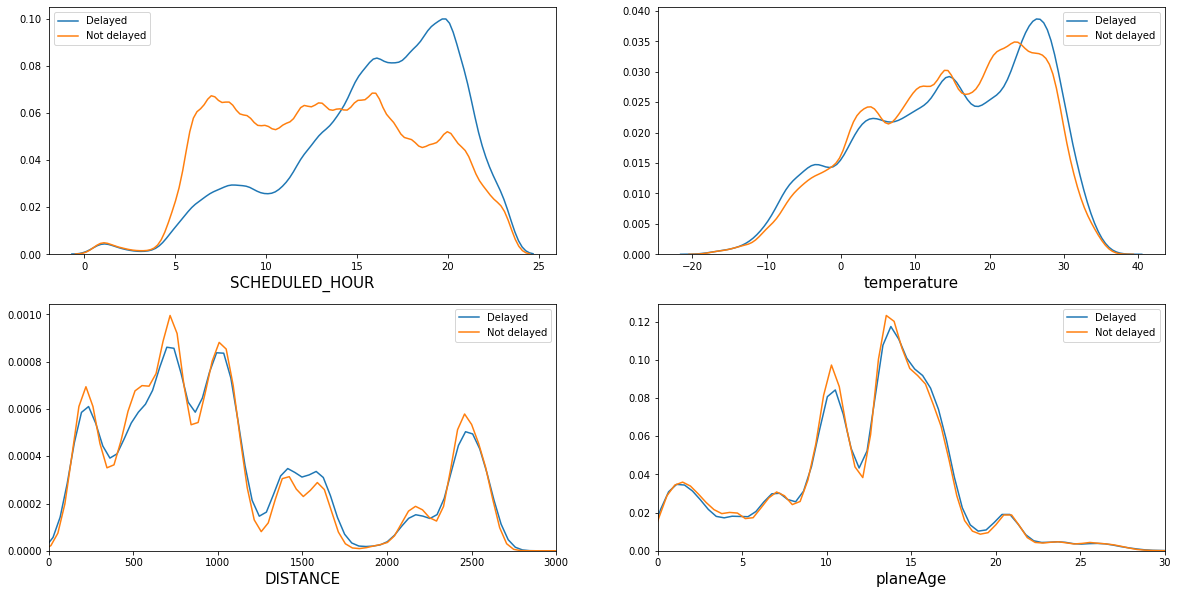

In [366]:
# Explore continuous data on delay

feature = ['SCHEDULED_HOUR','temperature','DISTANCE','planeAge']
f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
sns.distplot(dfdelay1[[feature[0]]], hist=False, label='Delayed', ax=ax0)
sns.distplot(dfdelay0[[feature[0]]], hist=False, label='Not delayed', ax=ax0)
sns.distplot(dfdelay1[[feature[1]]], hist=False, label='Delayed', ax=ax1)
sns.distplot(dfdelay0[[feature[1]]], hist=False, label='Not delayed', ax=ax1)
sns.distplot(dfdelay1[[feature[2]]], hist=False, label='Delayed', ax=ax2)
sns.distplot(dfdelay0[[feature[2]]], hist=False, label='Not delayed', ax=ax2)
sns.distplot(dfdelay1[[feature[3]]], hist=False, label='Delayed', ax=ax3)
sns.distplot(dfdelay0[[feature[3]]], hist=False, label='Not delayed', ax=ax3)
ax0.set_xlabel(feature[0],fontsize=15)
ax1.set_xlabel(feature[1],fontsize=15)
ax2.set_xlabel(feature[2],fontsize=15)
ax3.set_xlabel(feature[3],fontsize=15)
ax2.set_xlim(0,3000)
ax3.set_xlim(0,30)
plt.show()

# 5. Feature Selection

In [175]:
# Check statistical significance of categorical variables on delay

from scipy.stats import chisquare
test_table1 = (pd.pivot_table(df, values='Day_1', index=['DELAY'], columns=['weather_snow'],
                              aggfunc=len).unstack('DELAY').values).reshape(-2,2).T
test_table2 = (pd.pivot_table(df, values='Day_1', index=['DELAY'], columns=['weather_fog'],
                              aggfunc=len).unstack('DELAY').values).reshape(-2,2).T
test_table3 = (pd.pivot_table(df, values='Day_1', index=['DELAY'], columns=['United'],
                              aggfunc=len).unstack('DELAY').values).reshape(-2,2).T
test_table4 = (pd.pivot_table(df, values='Day_1', index=['DELAY'], columns=['DEPARTURE'],
                              aggfunc=len).unstack('DELAY').values).reshape(-2,2).T
test_table5 = (pd.pivot_table(df0, values='DATE', index=['DELAY'], columns=['DAY_OF_WEEK'],
                              aggfunc=len).unstack('DELAY').values).reshape(-2,2).T

display('Chi-test: Does SNOW impact flight punctuality?')
display(test_table1, f'p-value = {chisquare(test_table1)[1][0]}')
display('Chi-test: Does FOG impact flight punctuality?')
display(test_table2, f'p-value = {chisquare(test_table2)[1][0]}')
display('Chi-test: Is UNITED Airlines worse than others on flight punctuality?')
display(test_table3, f'p-value = {chisquare(test_table3)[1][0]}')
display('Chi-test: Are DEPARTURE flights more likely to be delayed?')
display(test_table4, f'p-value = {chisquare(test_table4)[1][0]}')
display('Chi-test: Does DAY OF THE WEEK impact flight punctuality?')
display(test_table5, f'p-value = {chisquare(test_table5)[1][0]}')

'Chi-test: Does SNOW impact flight punctuality?'

array([[143335,    320],
       [ 41197,    290]])

'p-value = 0.0'

'Chi-test: Does FOG impact flight punctuality?'

array([[141492,   2163],
       [ 40424,   1063]])

'p-value = 0.0'

'Chi-test: Is UNITED Airlines worse than others on flight punctuality?'

array([[ 35763, 107892],
       [  8893,  32594]])

'p-value = 0.0'

'Chi-test: Are DEPARTURE flights more likely to be delayed?'

array([[72556, 71099],
       [19939, 21548]])

'p-value = 0.0'

'Chi-test: Does DAY OF THE WEEK impact flight punctuality?'

array([[21216, 20204, 22060, 21003, 21995, 16709, 20468],
       [ 6557,  7095,  6350,  6964,  5837,  3669,  5015]])

'p-value = 0.0'

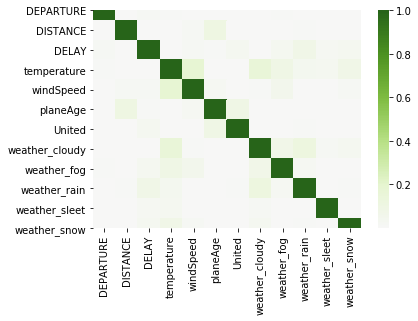

In [364]:
# Double check there is no strong collinearity between predictors

dfcorr = df.iloc[:,:12] # not showing dummy variable for days and hours
sns.heatmap(abs(dfcorr.corr()), cmap="PiYG", center=0)
plt.show()

In [322]:
print('List of predictors and target to be fed into model')
display(df.dtypes)
display(df.shape)

List of predictors and target to be fed into model


DEPARTURE           int64
DISTANCE            int64
DELAY               int64
temperature       float64
windSpeed         float64
planeAge          float64
United              int64
weather_cloudy      uint8
weather_fog         uint8
weather_rain        uint8
weather_sleet       uint8
weather_snow        uint8
Day_1               uint8
Day_2               uint8
Day_3               uint8
Day_5               uint8
Day_6               uint8
Day_7               uint8
Hour_5              uint8
Hour_6              uint8
Hour_7              uint8
Hour_8              uint8
Hour_9              uint8
Hour_10             uint8
Hour_11             uint8
Hour_12             uint8
Hour_13             uint8
Hour_14             uint8
Hour_15             uint8
Hour_16             uint8
Hour_17             uint8
Hour_18             uint8
Hour_19             uint8
Hour_20             uint8
Hour_21             uint8
Hour_22             uint8
Hour_23             uint8
dtype: object

(185142, 37)

### Summary of predictors
**Target** = Delay [Yes=1/No=0]

**Predictors Category 1 : Airport/Airline**
1. Departure or arrival [Yes=1/No=0]
2. Distance of flight route - in miles
3. Age of plane - in years
4. United Airlines or competitors [Yes=1/No=0]

**Predictors Category 2 : Weather measurements**
5. Wind speed in mph
6. Temperature in C

**Predictors Category 3 : Weather & time as categorical variables:**
7. Type of weather (5 types) - rain, snow, sleet, fog, cloudy [Yes=1/No=0]
8. Day of the week (6 days) [Yes=1/No=0]
9. Hour of the day (20 hours) [Yes=1/No=0]

# 6. Prepare for modelling

In [19]:
# Prepocessing
import itertools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

# Logistic regression
from sklearn.linear_model import LogisticRegression

# Decision trees & ensemble methods
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Classifiers: KNN & SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

# Unsupervised: PCA & Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering

### 6.1 Train-Test split & Class imbalance

In [370]:
# Split target and predictors

y = df['DELAY']
X = df.drop('DELAY', axis=1)

# Split test data

X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Split train and validation data

X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=0.30, random_state=42)

In [371]:
# Check and handle imbalance data using SMOTE:

print('Original set')
display(pd.Series(y_train).value_counts())

smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)

print('After treating class imbalance')
display(pd.Series(y_train).value_counts())

Original set


0    70445
1    20274
Name: DELAY, dtype: int64

After treating class imbalance


1    70445
0    70445
Name: DELAY, dtype: int64

### 6.2 Automate processes

In [492]:
# Automate Confusion Matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, f1_score, auc

# Save result of each confusion matrix to be compared between different models later
def cf_measures(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = cf_matrix[0][0], cf_matrix[0][1], cf_matrix[1][0], cf_matrix[1][1]
    TPR = round(TP/(TP+FN),4) # Power
    FPR = round(FP/(FP+TN),4) # Alpha
    FNR = round(FN/(FN+TP),4) # Beta
    TNR = round(TN/(TN+FN),4)
    Acc = round((TP+TN)/np.sum(cf_matrix),4)
    Pre = round(TP/(TP+FP),4)
    F1S = round(f1_score(y, y_pred),4)
    return TPR, FPR, FNR, TNR, Acc, Pre, F1S

# Plot confusion matrix and display summary
def cf_matrix(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    plt.imshow(cf_matrix,  cmap=plt.cm.Blues)
    thresh = cf_matrix.max() / 2.  
    for i, j in itertools.product(range(cf_matrix.shape[0]), range(cf_matrix.shape[1])):
            plt.text(j, i, cf_matrix[i, j],
                     horizontalalignment='center', fontsize=12,
                     color='white' if cf_matrix[i, j] > thresh else 'black')
    plt.ylabel('TRUE Delay')
    plt.xlabel('PREDICTED Delay')
    plt.xticks([0,1])
    
    TPR, FPR, FNR, TNR, Acc, Pre, F1S = cf_measures(y, y_pred)    
    print (f'FalsePos={round(FPR*100,2)}%, FalseNeg={round(FNR*100,2)}%')
    print(f'TruePos={round(TPR*100,2)}%, TrueNeg={round(TNR*100,2)}%')
    print(f'Accuracy={round(Acc*100,2)}%, Precision={round(Pre*100,2)}%')
    print(f'F1score={round(F1S*100,2)}%')
    return ('Confusion Matrix')

In [493]:
# Automate roc_curve, auc
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

def plot_roc_auc(X_train, y_train, X_val, y_val, trained_model, title='ROC curve and AUC'):
    FPR1, TPR1, thresholds1 = roc_curve(y_train, trained_model.predict_proba(X_train)[:,1])
    FPR2, TPR2, thresholds2 = roc_curve(y_val, trained_model.predict_proba(X_val)[:,1])
    AUC1 = auc(FPR1, TPR1)
    AUC2 = auc(FPR2, TPR2)
    
    plt.figure()
    lw = 2
    plt.plot(FPR1, TPR1, color='blue', lw=lw, label='Training')
    plt.plot(FPR2, TPR2, color='red', lw=lw, label='Validation', linestyle='dashdot')
    
    plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='dashed')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Pos rate')
    plt.ylabel('True Pos rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
    return print(f'AUC: Train={round(AUC1*100,2)}%, Validation={round(AUC2*100,2)}%')

### 6.3 Explore PCA

k=5, 0.17757
k=10, 0.99494


[0.03854596 0.0362977  0.03476517 0.0343499  0.03360993]


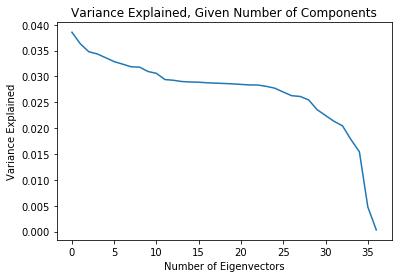

In [319]:
# PCA

df_TF = StandardScaler().fit_transform(df)
fit = PCA()
pca = fit.fit_transform(df_TF)
k=5

plt.plot(fit.explained_variance_ratio_)
plt.title("Variance Explained, Given Number of Components")
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Variance Explained")

print(f'k={k}, {round(fit.explained_variance_ratio_[:k].sum(),5)}')
print(f'k={10}, {round(fit.explained_variance_ratio_[:35].sum(),5)}')
print('\n')
print(fit.explained_variance_ratio_[:k])

# 7. Train and evaluate models

Models to explore:
1. Logistic Regression as Baseline
2. Decision Tree
3. Random Forest
4. Adaboost
5. Gradient Boost
6. XGBoost
7. KNN
8. Support Vector Machines

### 7.1 Logistic Regression as Baseline
Hyperparameters: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


FalsePos=8.4%, FalseNeg=28.51%
TruePos=71.49%, TrueNeg=76.26%
Accuracy=81.55%, Precision=89.49%
F1score=79.48%


'Confusion Matrix'

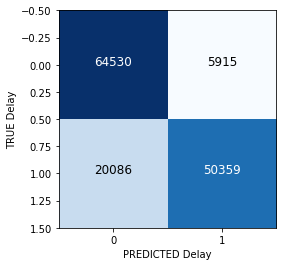

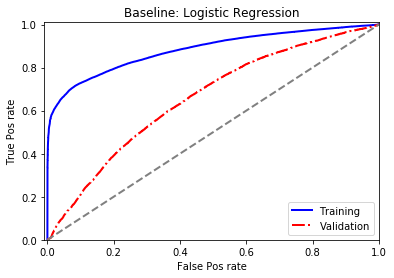

AUC: Train=88.21%, Validation=65.74%


None

Pipeline(memory=None,
         steps=[('ssc',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logreg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=True,
                                    warm_start=False))],
         verbose=False)

In [494]:
# Baseline: Logistic regression

baseline = Pipeline([('ssc', StandardScaler()),
                     ('logreg', LogisticRegression(verbose=True))])
baseline.fit(X_train, y_train)
y_pred_train = baseline.predict(X_train)
baseline_measures = cf_measures(y_train, y_pred_train)

display(cf_matrix(y_train, y_pred_train))
display(plot_roc_auc(X_train, y_train, X_val, y_val, baseline, 'Baseline: Logistic Regression'))
display(baseline)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


FalsePos=43.06%, FalseNeg=33.99%
TruePos=66.01%, TrueNeg=62.62%
Accuracy=61.48%, Precision=60.52%
F1score=63.15%


'Confusion Matrix'

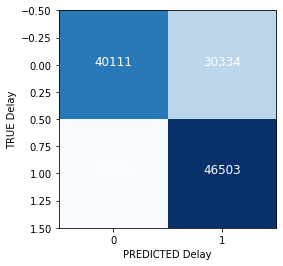

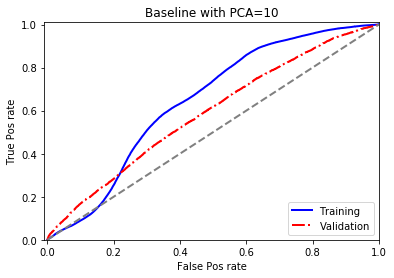

AUC: Train=64.57%, Validation=58.81%


None

In [495]:
# Baseline: Logistic regression - evaluate with PCA

n_pca=10
baseline2 = Pipeline([('ssc', StandardScaler()),
                      ('pca', PCA(n_components=15)),
                      ('logreg', LogisticRegression(verbose=True))])
baseline2.fit(X_train, y_train)
y_pred_train = baseline2.predict(X_train)
baseline2_measures = cf_measures(y_train, y_pred_train)

display(cf_matrix(y_train, y_pred_train))
display(plot_roc_auc(X_train, y_train, X_val, y_val, baseline2, 'Baseline with PCA=10'))

In [387]:
# Linear Regression parameter tuning

# penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’ - TO BE TUNED
# dual, default=False
# tol, default=1e-4
# C, default=1.0 - TO BE TUNED
# fit_intercept, default=True
# intercept_scaling, default=1
# class_weight, dict or ‘balanced’, default=None
# solver, {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’} default=’lbfgs’ - TO BE TUNED
# max_iter, default=100
# multi_class, {‘auto’, ‘ovr’, ‘multinomial’} default=’auto’
# warm_start, default=False
# n_jobs, default=None
# l1_ratio, default=None

start = time.time()
print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')
logreg = Pipeline([('ssc', StandardScaler()),
                   ('logr', LogisticRegression())])                
logreg_params = {'logr__C': [1, 100], 
                 'logr__penalty': ['l1', 'l2'],
                 'logr__solver': ['lbfgs', 'saga']
                }
kfold = 3
logreg_gs = GridSearchCV(estimator=logreg, param_grid=logreg_params, scoring='accuracy',
                         cv=kfold, verbose=1, return_train_score=True)
logreg_gs.fit(X_train, y_train)
print('Best accuracy: %.4f' % logreg_gs.best_score_)
print('Best params:\n', logreg_gs.best_params_)
print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')
print(f'Avg time per fit: {round(np.mean(logreg_gs.cv_results_["mean_fit_time"]),1)} sec')

Start: 18:02:18
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   28.1s finished


Best accuracy: 0.7967
Best params:
 {'logr__C': 100, 'logr__penalty': 'l1', 'logr__solver': 'saga'}
End: 18:02:48 in 0.5 minutes
Avg time per fit: 1.1 sec


In [320]:
# logreg_gs.cv_results_

FalsePos=8.4%, FalseNeg=28.51%
TruePos=71.49%, TrueNeg=76.26%
Accuracy=81.55%, Precision=89.49%
F1score=79.48%


'Confusion Matrix'

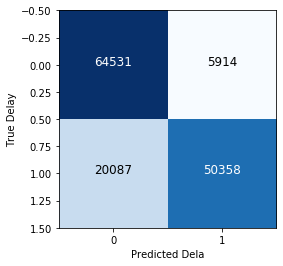

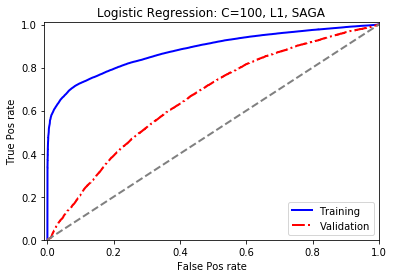

AUC: Train=88.21%, Validation=65.74%


None

Pipeline(memory=None,
         steps=[('ssc',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logreg2',
                 LogisticRegression(C=100, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [456]:
# Logistic regression with tuned hyperparameters, no PCA

logreg2 = Pipeline([('ssc', StandardScaler()),
                    ('logreg2', LogisticRegression(C=100, penalty='l1', solver='saga'))])
logreg2.fit(X_train, y_train)
y_pred_train = logreg2.predict(X_train)
logreg2_measures = cf_measures(y_train, y_pred_train)

display(cf_matrix(y_train, y_pred_train))
display(plot_roc_auc(X_train, y_train, X_val, y_val, logreg2, 'Logistic Regression: C=100, L1, SAGA'))
display(logreg2)

### 7.2 Decision Tree
Hyperparameters: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

FalsePos=0.0%, FalseNeg=0.0%
TruePos=100.0%, TrueNeg=100.0%
Accuracy=100.0%, Precision=100.0%
F1score=100.0%


'Confusion Matrix'

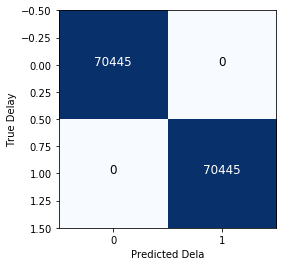

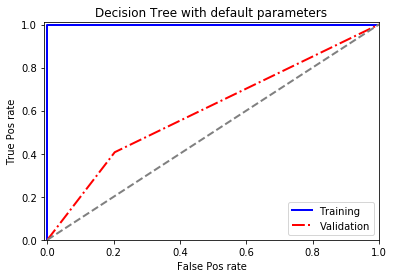

AUC: Train=100.0%, Validation=60.18%


None

Pipeline(memory=None,
         steps=[('ssc',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [457]:
# Decision Tree with default hyperparameters

dtree = Pipeline([('ssc', StandardScaler()),
                  ('tree', DecisionTreeClassifier())])
dtree.fit(X_train, y_train)
y_pred_train = dtree.predict(X_train)
dtree_measures = cf_measures(y_train, y_pred_train)

display(cf_matrix(y_train, y_pred_train))
display(plot_roc_auc(X_train, y_train, X_val, y_val, dtree, 'Decision Tree with default parameters'))
display(dtree)

In [395]:
# Decision Tree parameter tuning

# criterion, {“gini”, “entropy”} default=”gini”
# splitter, {“best”, “random”} default=”best”
# max_depth, default=None
# min_samples_split, default=2 - TO BE TUNED
# min_samples_leaf, default=1 - TO BE TUNED
# min_weight_fraction_leaf, default=0.0
# max_features, {“auto”, “sqrt”, “log2”} default=None
# max_leaf_nodes, default=None
# min_impurity_decrease, default=0.0

start = time.time()
print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')
dtree = Pipeline([('ssc', StandardScaler()),
                   ('dtree', DecisionTreeClassifier())])                
dtree_params = {'dtree__min_samples_split': list(range(2,2+4*4,4)),
                'dtree__min_samples_leaf': list(range(1,1+5*4,5))
               }
kfold = 3
dtree_gs = GridSearchCV(estimator=dtree, param_grid=dtree_params, scoring='accuracy',
                        cv=kfold, verbose=1, return_train_score=True)
dtree_gs.fit(X_train, y_train)
print('Best accuracy: %.4f' % dtree_gs.best_score_)
print('Best params:\n', dtree_gs.best_params_)
print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')
print(f'Avg time per fit: {round(np.mean(dtree_gs.cv_results_["mean_fit_time"]),1)} sec')

Start: 18:17:02
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  1.3min finished


Best accuracy: 0.7867
Best params:
 {'dtree__min_samples_leaf': 16, 'dtree__min_samples_split': 2}
End: 18:18:25 in 1.4 minutes
Avg time per fit: 1.5 sec


FalsePos=8.19%, FalseNeg=19.08%
TruePos=80.92%, TrueNeg=82.79%
Accuracy=86.37%, Precision=90.81%
F1score=85.58%


'Confusion Matrix'

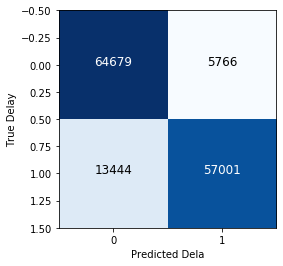

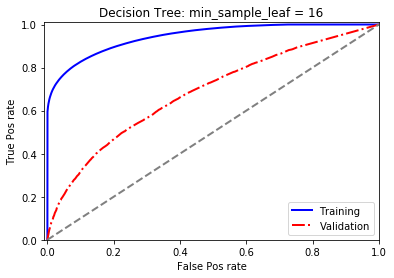

AUC: Train=94.47%, Validation=68.4%


None

Pipeline(memory=None,
         steps=[('ssc',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=16,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [458]:
# Decision Tree with tuned hyperparameters

dtree1 = Pipeline([('ssc', StandardScaler()),
                  ('tree', DecisionTreeClassifier(min_samples_leaf=16, min_samples_split=2))])
dtree1.fit(X_train, y_train)
y_pred_train = dtree1.predict(X_train)
dtree1_measures = cf_measures(y_train, y_pred_train)
display(cf_matrix(y_train, y_pred_train))
display(plot_roc_auc(X_train, y_train, X_val, y_val, dtree1, 'Decision Tree: min_sample_leaf = 16'))
display(dtree1)

# 8. Model selection & threshold selection

In [ ]:
# A = cost of FP - cost of TN
# B = cost of FN - cost of TP
# Metz's m = [(1-Prevalence) / Prevalence] * (A/B)
# fm = TPR - m.FPR
# After calc fm for multiple cases, select one with highest fm 

# 9. Summary of results

In [463]:
# Summary of results

results_list = [['Baseline: Logistic reg'] + ['default'] + list(baseline_measures),
                ['Decision Tree'] + ['min_sample_leaf=16'] + list(dtree1_measures)]

results_table = pd.DataFrame(columns=['Measures', 'Hyperparams',
                                      'TruePos', 'FalsePos', 'FalseNeg', 'TrueNeg',
                                      'Accuracy', 'Precision', 'F1 score'])
for result in results_list:
    results_table.loc[len(results_table)] = result
print('Summary of results from training models:')
results_table

Summary of results from training models:


,Measures,Hyperparams,TruePos,FalsePos,FalseNeg,TrueNeg,Accuracy,Precision,F1 score
0,Baseline: Logistic reg,default,0.7149,0.0840,0.2851,0.7626,0.8155,0.8949,0.7948
1,Decision Tree,min_sample_leaf=16,0.8092,0.0819,0.1908,0.8279,0.8637,0.9081,0.8558


# To do list

- Evaluate strongest predictors - important to explain to stakeholder
- Choose to reduce False Negative: we do not want airline to think that there's no delay when there is one
- Threshold selection, Metz's m, cost of error, fm

# 10. Conclusion and Recommendations